In [ ]:
!hostname

n21.clstr


This Jupyter notebook is used to explore the relationship between Precipitation and ROS 
- 
- Compares Precip Accumulation to ROS hours 

In [1]:
import xarray as xr
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import re
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import pearsonr, spearmanr

Loading in the data 
-

In [2]:
path='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files'
pattern=f'ROS_Monthly*.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
dataP = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')
dataP = dataP.fillna(0)

#start_year = '1950-1951'
start_year = '1959-1960'
dataP = dataP.sel(season=dataP.season >= start_year)
seasons=dataP['season']
lat=dataP['XLAT']
lon=dataP['XLONG']

In [3]:
path='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/'
pattern=f'ROS_Monthly*.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
dataT= xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')
dataT = dataT.fillna(0)

start_year = '1950-1951'
dataT = dataT.sel(season=dataT.season >= start_year)

In [29]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)

anc_lat=(61.2176)
anc_lon=(-149.8997)

bethel_lat=(60.7943)
bethel_lon=(-161.7694)

In [30]:
ANC_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Municipality of Anchorage']
MATSU_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Matanuska-Susitna Borough']
KENAI_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Kenai Peninsula Borough']
BETHEL_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Bethel Census Area']
ANC_boundary= borough_boundaries[borough_boundaries['CommunityN'] == 'Municipality of Anchorage']

I need to remask the data....
-

In [6]:
os.chdir("/import/beegfs/CMIP6/wrf_era5")
geo_em_path = "geo_em.d02.nc"
geo = xr.open_dataset(geo_em_path)
oceanmask=geo['LU_INDEX']
oceanmask=oceanmask.squeeze(dim='Time')
#oceanmask_expanded = oceanmask.expand_dims(Time=data.Time)

dataT = dataT.where(oceanmask != 17)
dataP = dataP.where(oceanmask != 17)

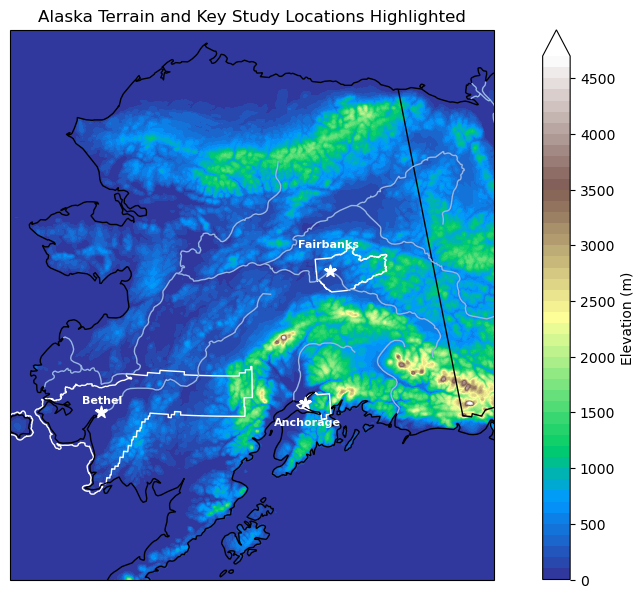

In [36]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
cmap = plt.get_cmap('terrain')
elevation=geo['HGT_M']
levels=np.arange(0,4800,100)
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10,6))
cf = ax.contourf(lon, lat,np.mean(elevation,axis=0), cmap=cmap, levels=levels,extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax,label='Elevation (m)')
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='white', zorder=12, s=80,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.6, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='white')

BETHEL_boundary.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(bethel_lon, bethel_lat, marker='*', color='white', zorder=12, s=80,label='Bethel', transform=ccrs.PlateCarree())
ax.text(bethel_lon, bethel_lat + 0.2, 'Bethel',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='white')

ANC_boundary.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(anc_lon, anc_lat, marker='*', color='white', zorder=12, s=80,label='Anchorage', transform=ccrs.PlateCarree())
ax.text(anc_lon, anc_lat - 0.7, 'Anchorage',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='white')

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS,zorder=9)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Alaska Terrain and Key Study Locations Highlighted")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

In [10]:
def compute_ros_hourly_normalized(data):
    """Function uses total ROS hours, number of active ROS pixels, and normalized ROS hours per pixel per season
    Returns ... tuple
            ros_hourly_totals : Total ROS hours per season
            n_pixels_per_season : Number of active pixels per season
            ros_hours_normalized : ROS hours normalized by number of active pixels """
    ros_hourly_totals = []
    n_pixels_per_season = []
    for i in range(len(data['ros_counts'].season)):
        ros_season = data['ros_counts'].isel(season=i)
        # Total ROS hours
        total = ros_season.sum().compute().item()
        ros_hourly_totals.append(total)
        # Number of pixels with ROS > 0
        n_pixels = (ros_season > 0).sum().compute().item()
        n_pixels_per_season.append(n_pixels)
    # Normalize ROS hours by number of active pixels
    ros_hours_normalized = [
        total / n if n > 0 else np.nan
        for total, n in zip(ros_hourly_totals, n_pixels_per_season)]
    return ros_hourly_totals, n_pixels_per_season, ros_hours_normalized


In [11]:
totals, pixel_counts, ros_hours_normalized = compute_ros_hourly_normalized(dataT)

In [12]:
def seasonal_sum(data_array, dim='season'):
    """
    Calculates the sum for each season in the given xarray DataArray
    Returns: List of seasonal sums 
    """
    avg_rain= []
    for i in range(len(dataP['rain_sum'].season)):
        avg=dataP['rain_sum'].isel(season=i).sum().compute().item()
        avg_rain.append(avg)
    return avg_rain

In [13]:
def seasonal_avg_sum(data_array, dim='season'):
    """
    Calculates the sum for each season in the given xarray DataArray
    Returns: List of seasonal sums 
    """
    avg_rain= []
    for i in range(len(dataP['rain_sum'].season)):
        avg=dataP['rain_sum'].isel(season=i).mean().compute().item()
        avg_rain.append(avg)
    return avg_rain


In [14]:
# Sum of total rain per season
rain_sum = seasonal_avg_sum(dataP['rain_sum'])

# Sum of ROS rain per season
rain_sum_ROS = seasonal_avg_sum(dataP['rain_ros_sum'])

print("Rain sum per season:", rain_sum)
print("ROS Rain sum per season:", rain_sum_ROS)


Rain sum per season: [5.372071266174316, 6.678106784820557, 7.191245079040527, 12.004563331604004, 4.691173553466797, 6.559455394744873, 3.329925060272217, 3.263955593109131, 10.093252182006836, 2.8276848793029785, 7.432754039764404, 6.100228786468506, 3.730172634124756, 4.049163341522217, 4.167048454284668, 3.9530751705169678, 3.077934503555298, 12.086125373840332, 4.090180397033691, 7.724730491638184, 10.134883880615234, 8.271013259887695, 6.522839069366455, 6.46805477142334, 8.737167358398438, 7.837936878204346, 10.57532024383545, 10.658453941345215, 6.176792144775391, 4.5339131355285645, 5.5035552978515625, 6.997896194458008, 5.399986267089844, 7.356782913208008, 8.29351806640625, 5.474870204925537, 4.413508415222168, 4.618700981140137, 7.058623313903809, 3.9400951862335205, 5.078032970428467, 10.114954948425293, 4.906125068664551, 15.522982597351074, 7.066768169403076, 8.409821510314941, 6.6072258949279785, 2.4928669929504395, 6.27145528793335, 5.75618314743042, 5.312450885772705,

In [15]:
#Finding the average Rain for each winter season 
rain_sum=[]
for i in range(len(dataP['rain_sum'].season)):
    avg=dataP['rain_sum'].isel(season=i).mean().compute().item()
    rain_sum.append(avg)
print(rain_sum)

[5.372071266174316, 6.678106784820557, 7.191245079040527, 12.004563331604004, 4.691173553466797, 6.559455394744873, 3.329925060272217, 3.263955593109131, 10.093252182006836, 2.8276848793029785, 7.432754039764404, 6.100228786468506, 3.730172634124756, 4.049163341522217, 4.167048454284668, 3.9530751705169678, 3.077934503555298, 12.086125373840332, 4.090180397033691, 7.724730491638184, 10.134883880615234, 8.271013259887695, 6.522839069366455, 6.46805477142334, 8.737167358398438, 7.837936878204346, 10.57532024383545, 10.658453941345215, 6.176792144775391, 4.5339131355285645, 5.5035552978515625, 6.997896194458008, 5.399986267089844, 7.356782913208008, 8.29351806640625, 5.474870204925537, 4.413508415222168, 4.618700981140137, 7.058623313903809, 3.9400951862335205, 5.078032970428467, 10.114954948425293, 4.906125068664551, 15.522982597351074, 7.066768169403076, 8.409821510314941, 6.6072258949279785, 2.4928669929504395, 6.27145528793335, 5.75618314743042, 5.312450885772705, 6.0897979736328125, 

In [16]:
#finding the average Rain for each winter season ONLY when ROS hours occured
rain_sum_ROS=[]
for i in range(len(dataP['rain_ros_sum'].season)):
    avg=dataP['rain_ros_sum'].isel(season=i).mean().compute().item()
    rain_sum_ROS.append(avg)
print(rain_sum_ROS)

[3.7749414443969727, 5.323812484741211, 6.01023530960083, 8.852203369140625, 3.80237078666687, 5.287691593170166, 2.5312647819519043, 2.54176664352417, 7.963364601135254, 2.0510759353637695, 5.572981357574463, 4.796566486358643, 2.972578287124634, 3.123732566833496, 3.1363675594329834, 3.0806896686553955, 2.454926013946533, 9.667057037353516, 2.947859525680542, 5.784184455871582, 7.166177749633789, 6.355307102203369, 5.120758533477783, 4.725161552429199, 6.593300819396973, 5.921976089477539, 8.27729320526123, 6.829590320587158, 4.7269062995910645, 3.4917569160461426, 4.086043834686279, 5.6465067863464355, 3.7544562816619873, 5.560793876647949, 6.029526233673096, 4.342864990234375, 3.3253817558288574, 3.458942174911499, 5.031624794006348, 2.5510551929473877, 4.0772223472595215, 7.5923380851745605, 3.9015567302703857, 9.936283111572266, 4.427206993103027, 6.3907341957092285, 5.082620620727539, 1.8845162391662598, 4.612206935882568, 4.67112922668457, 3.932508707046509, 4.789249420166016, 

In [17]:
print('Average Rain Nov-Mar', np.mean(rain_sum))
print('When ROS occurs average Rain',np.mean(rain_sum_ROS))

Average Rain Nov-Mar 6.856181275099516
When ROS occurs average Rain 5.040206737816334


ValueError: x and y must have same first dimension, but have shapes (64,) and (73,)

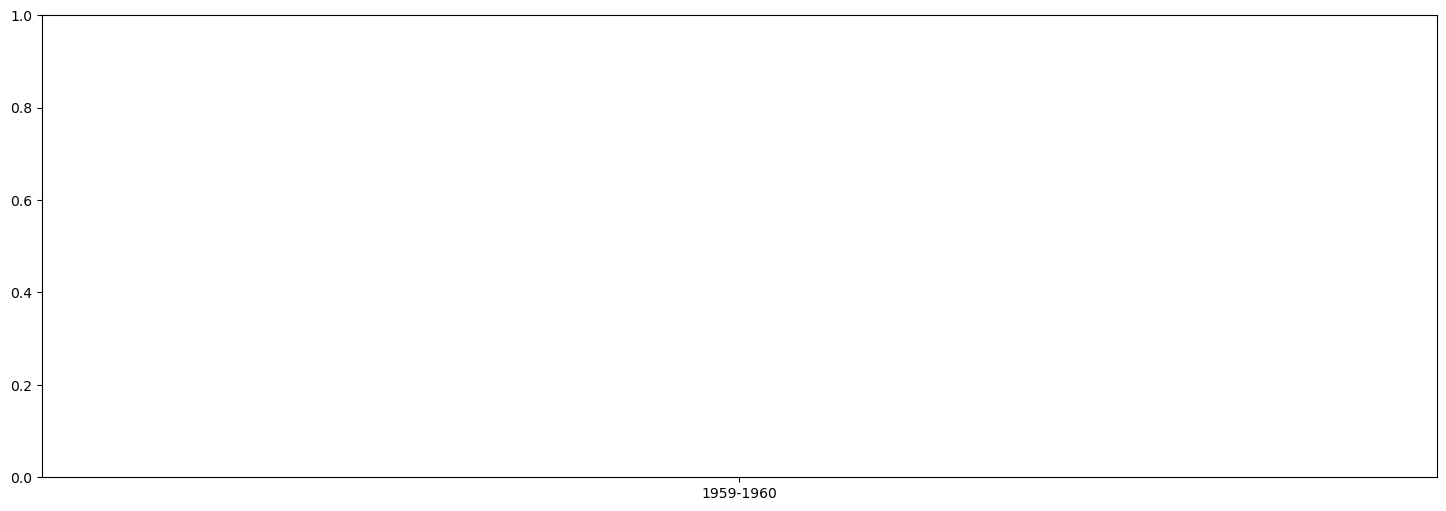

In [18]:
fig, ax1 = plt.subplots(figsize=(18, 6))

ax1.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Normalized ROS Hours', color='blue')
ax1.set_ylim(0,100)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(seasons, rain_sum_ROS, marker='o', linestyle='-', color='black', label='Rain (mm)')
plt.axhline(np.nanmean(rain_sum_ROS), color='black', linestyle='--') 
ax2.set_ylabel('Rainfall (mm)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.title('Total ROS Hours and Sum of Rain per Winter Season')
fig.tight_layout()
plt.show()

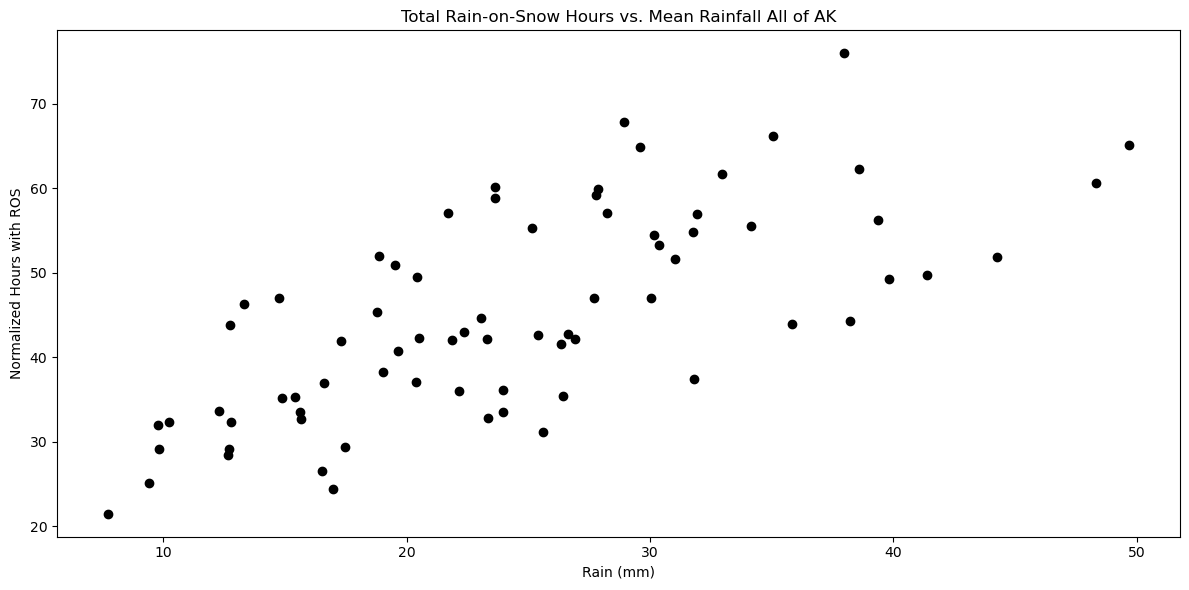

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(rain_sum_ROS, ros_hours_normalized, marker='o', linestyle='', color='black')
plt.title('Total Rain-on-Snow Hours vs. Mean Rainfall All of AK')
plt.xlabel('Rain (mm)')
plt.ylabel('Normalized Hours with ROS')
plt.tight_layout()
plt.show()

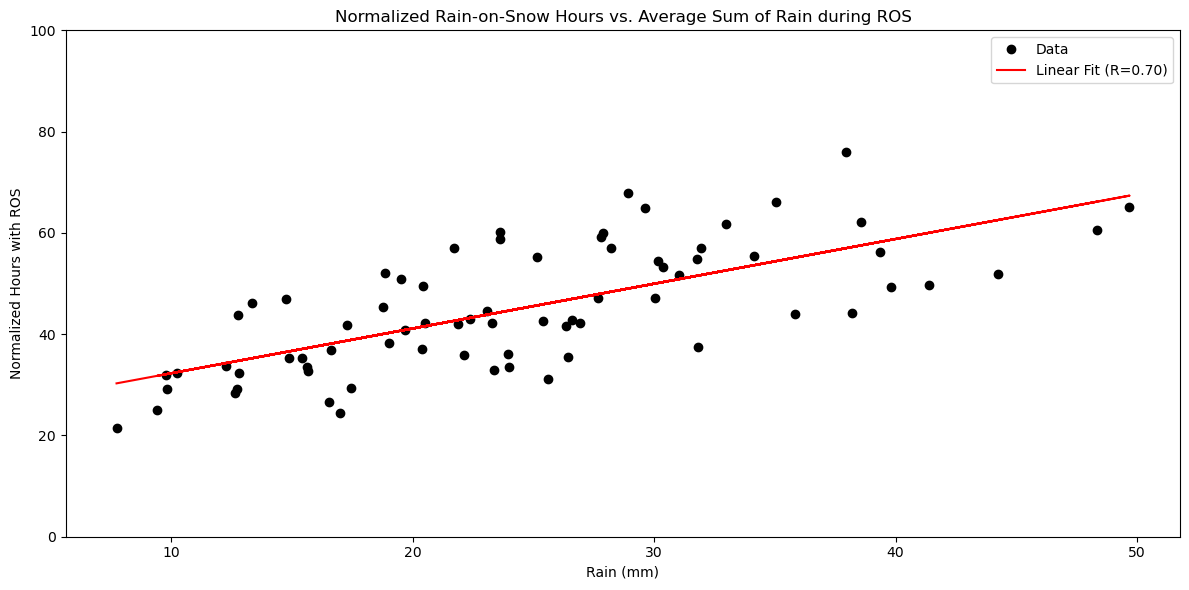

In [18]:
slope, intercept, r_value, p_value, std_err = linregress(rain_sum_ROS, ros_hours_normalized)
x = np.array(rain_sum_ROS)
y_fit = slope * x + intercept

plt.figure(figsize=(12, 6))
plt.plot(rain_sum_ROS, ros_hours_normalized, marker='o', linestyle='', color='black', label='Data')
plt.plot(x, y_fit, color='red', label=f'Linear Fit (R={r_value:.2f})')

plt.title('Normalized Rain-on-Snow Hours vs. Average Sum of Rain during ROS')
plt.xlabel('Rain (mm)')
plt.ylabel('Normalized Hours with ROS')
plt.legend()
plt.ylim(0,100)

plt.tight_layout()
plt.gcf().patch.set_alpha(0.0)
plt.show()

TypeError: Input z must be 2D, not 3D

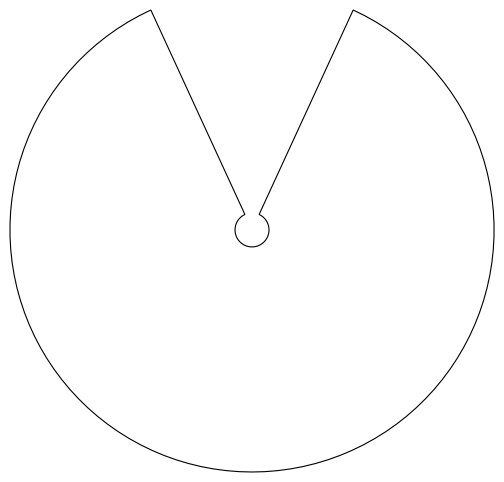

In [19]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
cmap = plt.get_cmap('Blues')
levels=np.linspace(0,100,200)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10,6))
cf = ax.contourf(lon, lat,np.mean(dataP['ros_counts'],axis=(0)), cmap=cmap,levels=levels, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Hours of ROS', ticks=np.arange(0, 110,10))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

#FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=10, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Hours of ROS Over Winter 1959–2022")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

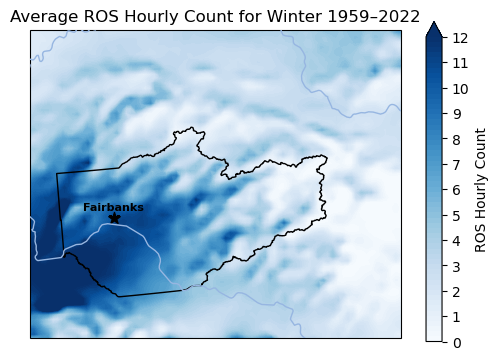

In [12]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.linspace(0, 12,60)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, np.mean(dataP['ros_counts'],axis=(0)), levels=levels,extend='max',cmap='Blues',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(np.arange(0,13,1))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')

ax.set_title("Average ROS Hourly Count for Winter 1959–2022")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

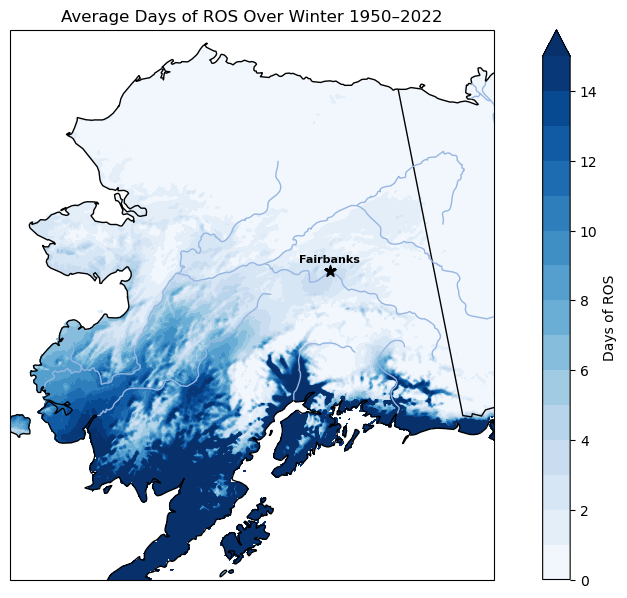

In [21]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
cmap = plt.get_cmap('Blues')
levels=np.arange(0,16,1)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10,6))
cf = ax.contourf(lon, lat,np.mean(dataP['ros_days_count'],axis=(0)), cmap=cmap,levels=levels, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Days of ROS')
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

#FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=10, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS,zorder=9)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Days of ROS Over Winter 1950–2022")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_247761/3433422048.py:1: RuntimeWarning: Mean of empty slice
  ros_avg_rain = np.nanmean(dataP['rain_ros_avg'],axis=0)


TypeError: Input z must be 2D, not 3D

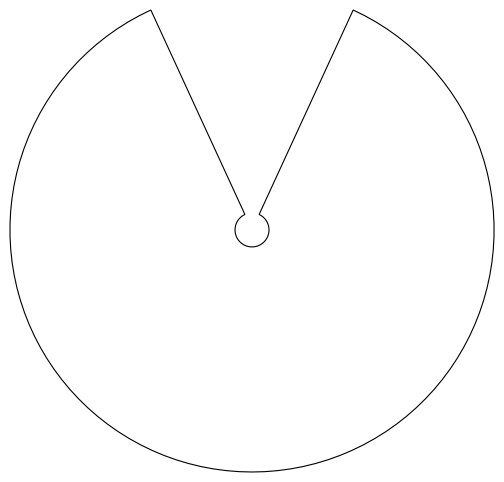

In [20]:
ros_avg_rain = np.nanmean(dataP['rain_ros_avg'],axis=0)

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.linspace(0, 1,50) 
cmap = plt.get_cmap('BuGn')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 6))
cf = ax.contourf(lon, lat, ros_avg_rain, levels=levels, cmap=cmap, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Rain per Hour (mm/hr)')
cbar.set_ticks(np.arange(0, 1.05, 0.05)[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

#FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=10, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=5)
ax.add_feature(cfeature.COASTLINE, zorder=5)
ax.add_feature(cfeature.RIVERS, zorder=5)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Hourly Rainfall During ROS Events\n Over Winter 1950–2022")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

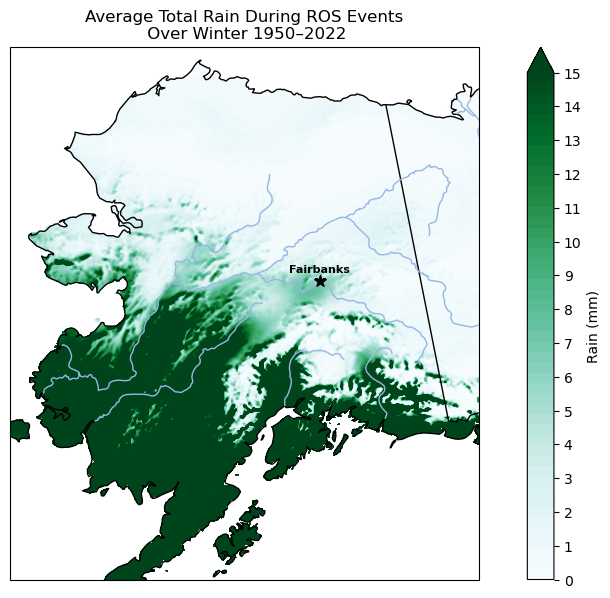

In [23]:
ros_avg_sum = np.mean(dataP['rain_ros_sum'],axis=0)

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.linspace(0, 15,50) 
cmap = plt.get_cmap('BuGn')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 6))
cf = ax.contourf(lon, lat, ros_avg_sum, levels=levels, cmap=cmap, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Rain (mm)')
cbar.set_ticks(np.arange(0, 15.5, 0.5)[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

#FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=10, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=5)
ax.add_feature(cfeature.COASTLINE, zorder=5)
ax.add_feature(cfeature.RIVERS, zorder=5)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Total Rain During ROS Events\n Over Winter 1950–2022")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

Breaking it into regions !

Period Analysis
-
Answering the questions how has rain on snow changed from the first climate normal of this data set through the most recent climanormal?

In [21]:
def period_mask_analysis(data, seasons, start_year, end_year):
    season_strings = seasons.values.astype(str)
    season_start_years = np.array([int(season.split('-')[0]) for season in season_strings])
    mask = (season_start_years >= start_year) & (season_start_years <= end_year)
    data_filtered = data.isel(season=np.where(mask)[0])
    return data_filtered

def seasonal_avg_data(data, variable):
    avg = np.mean(data[variable], axis=0)
    avg = avg.fillna(0)
    return avg


1950 - 1979
1991 - 2020 

WMO uses 1960-1990 as standard climate normals or could do 1993–2022

In [1]:
dataT_first30_1950_1979 = period_mask_analysis(dataT, seasons, 1950, 1979)
dataP_first30_1950_1979 = period_mask_analysis(dataP, seasons, 1950, 1979)
ros_tally_1950_1979 = seasonal_avg_data(dataT_first30_1950_1979, 'ros_counts')
ros_days_count_1950_1979 = seasonal_avg_data(dataT_first30_1950_1979, 'ros_days_count')
ros_hourly_rainfall_1950_1979 = seasonal_avg_data(dataP_first30_1950_1979, 'rain_ros_avg')
ros_avgsum_rainfall_1950_1979=seasonal_avg_data(dataP_first30_1950_1979,'rain_ros_sum')

dataT_last30_1991_2020 = period_mask_analysis(dataT, seasons, 1991, 2020)
dataP_last30_1991_2020 = period_mask_analysis(dataP, seasons, 1991, 2020)
ros_tally_1991_2020 = seasonal_avg_data(dataT_last30_1991_2020, 'ros_counts')
ros_days_count_1991_2020 = seasonal_avg_data(dataT_last30_1991_2020, 'ros_days_count')
ros_hourly_rainfall_1991_2020 = seasonal_avg_data(dataP_last30_1991_2020, 'rain_ros_avg')
ros_avgsum_rainfall_1991_2020=seasonal_avg_data(dataP_last30_1991_2020,'rain_ros_sum')

NameError: name 'period_mask_analysis' is not defined

check

In [23]:
test=ros_days_count_1950_1979.fillna(0)
nan_mask = np.isnan(test)
# Check if there are any NaNs at all
if nan_mask.any():
    print("There are NaNs in the DataArray")
else:
    print('no nans!')


: 

In [ ]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

#fig.suptitle("Average Days of ROS", y=0.9)
#levels = np.arange(0, 11, 1) 
levels=np.linspace(0,10,50)

cf1 = axs[0].contourf(lon, lat, ros_days_count_1950_1979, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
axs[0].set_title("Average Days of ROS from 1950-1979")

cf2 = axs[1].contourf(lon, lat, ros_days_count_1991_2020, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
axs[1].set_title("Average Days of ROS from 1991-2020")

for ax in axs:
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8,color='black')
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
fig.colorbar(cf1, cax=cbar_ax, orientation='horizontal', label='Average Days of ROS', ticks=np.arange(0, 11, 1)[::2])

fig.patch.set_alpha(0.0)

plt.show()

/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


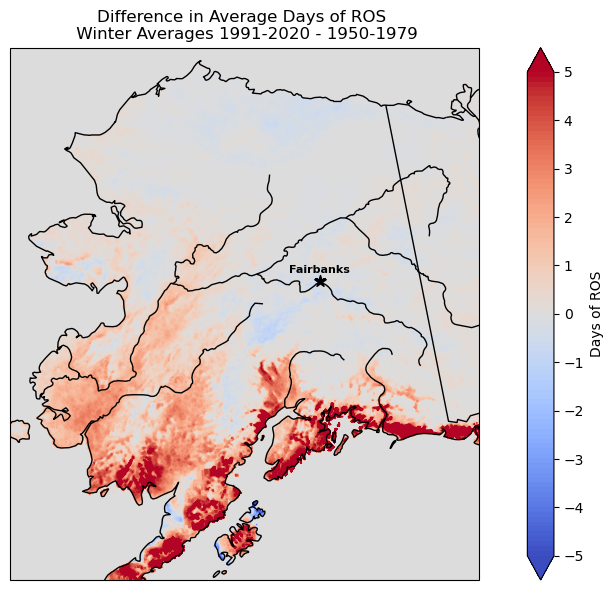

In [27]:
days_difference_1991_2020_1950_1979=(ros_days_count_1991_2020-ros_days_count_1950_1979).compute()
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
cmap = plt.get_cmap('coolwarm')
levels=np.linspace(-5,5,100)
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10,6))
cf = ax.contourf(lon, lat,days_difference_1991_2020_1950_1979, cmap=cmap,levels=levels, extend='both',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Days of ROS')
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
cbar.set_ticks(np.arange(-5,6,1))

#FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=10, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=8)
ax.add_feature(cfeature.COASTLINE, zorder=8)
ax.add_feature(cfeature.RIVERS, zorder=8,color='black')

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Difference in Average Days of ROS \n Winter Averages 1991-2020 - 1950-1979")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

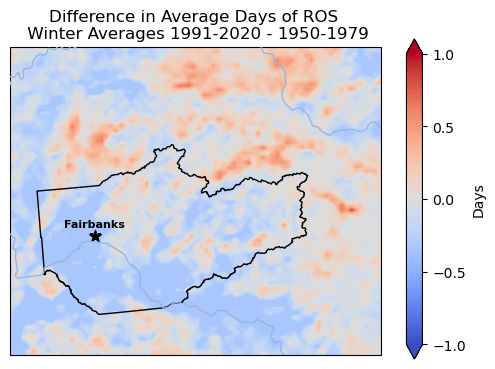

In [28]:
days_difference_1991_2020_1950_1979=(ros_days_count_1991_2020-ros_days_count_1950_1979).compute()

AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels=np.linspace(-1,1,100)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat,days_difference_1991_2020_1950_1979, levels=levels,extend='both',cmap='coolwarm',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Days')
cbar.set_ticks(np.arange(-1,1.1, 0.1)[::5])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')

ax.set_title("Difference in Average Days of ROS \n Winter Averages 1991-2020 - 1950-1979")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.patch.set_alpha(0.0)
plt.show()

/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


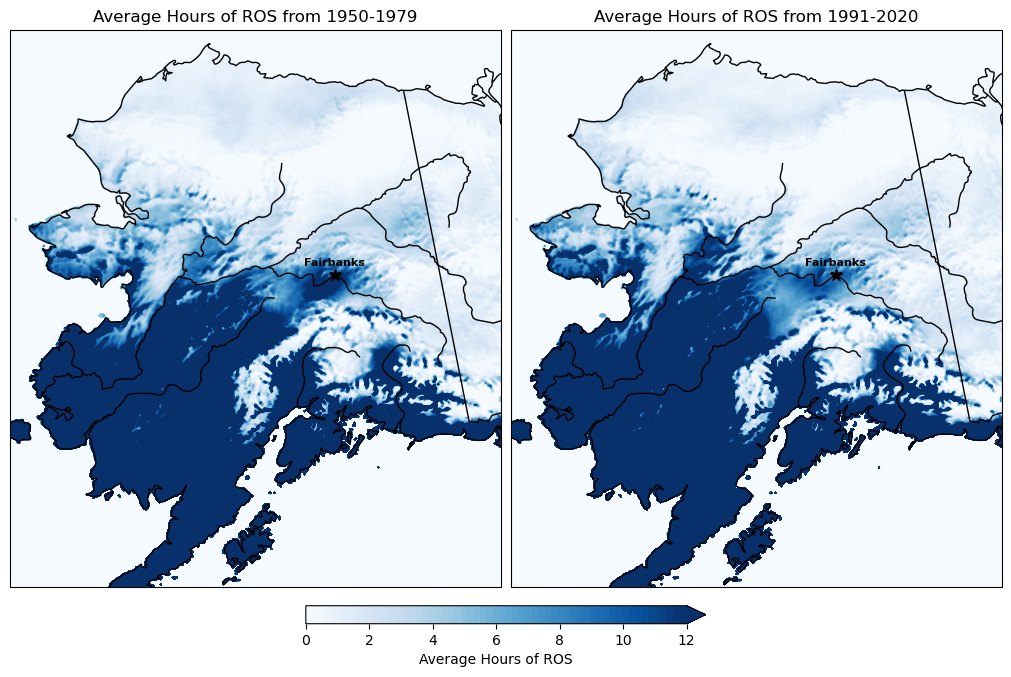

In [29]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

#fig.suptitle("Average Hours of ROS", y=0.9)
 
levels=np.linspace(0,12,60)

cf1 = axs[0].contourf(lon, lat, ros_tally_1950_1979, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
axs[0].set_title("Average Hours of ROS from 1950-1979")

cf2 = axs[1].contourf(lon, lat, ros_tally_1991_2020, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
axs[1].set_title("Average Hours of ROS from 1991-2020")

for ax in axs:
    #FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=10, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=10, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8,color='black')
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
fig.colorbar(cf2, cax=cbar_ax, orientation='horizontal', label='Average Hours of ROS', ticks=np.arange(0, 13, 1)[::2])

fig.patch.set_alpha(0.0)

plt.show()

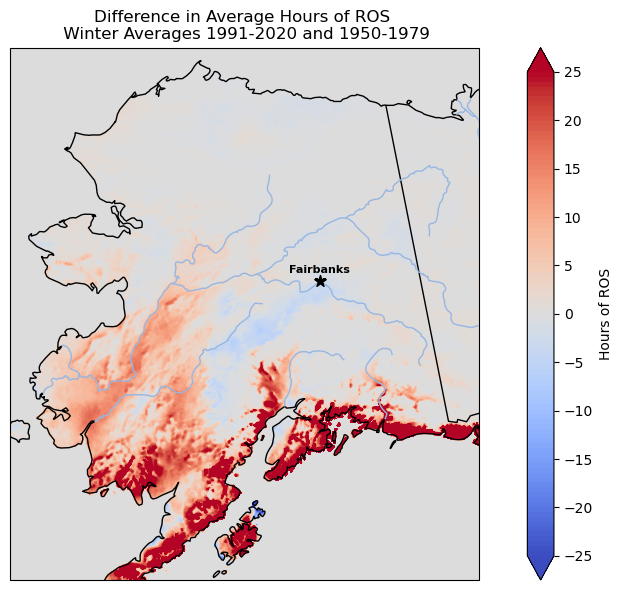

In [30]:
tally_difference_1991_2020_1950_1979=(ros_tally_1991_2020-ros_tally_1950_1979).compute()

AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
cmap = plt.get_cmap('coolwarm')
levels = np.linspace(-25, 25, 100)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10,6))
cf = ax.contourf(lon, lat,tally_difference_1991_2020_1950_1979, cmap=cmap,levels=levels, extend='both',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Hours of ROS')
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
cbar.set_ticks(np.arange(-25, 30, 5))
#FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=10, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Difference in Average Hours of ROS \n Winter Averages 1991-2020 and 1950-1979")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

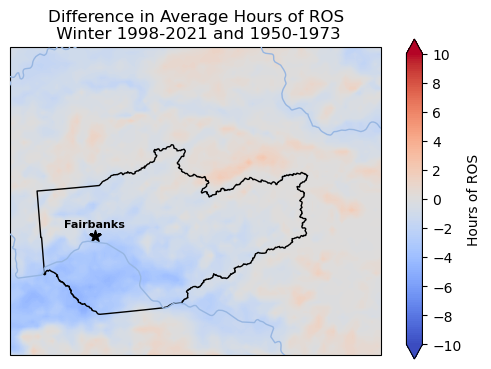

In [31]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels=np.linspace(-10,10,150)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat,tally_difference_1991_2020_1950_1979, levels=levels,extend='both',cmap='coolwarm',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Hours of ROS')
cbar.set_ticks(np.arange(-10,11,1)[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')

ax.set_title("Difference in Average Hours of ROS\n Winter 1998-2021 and 1950-1973")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

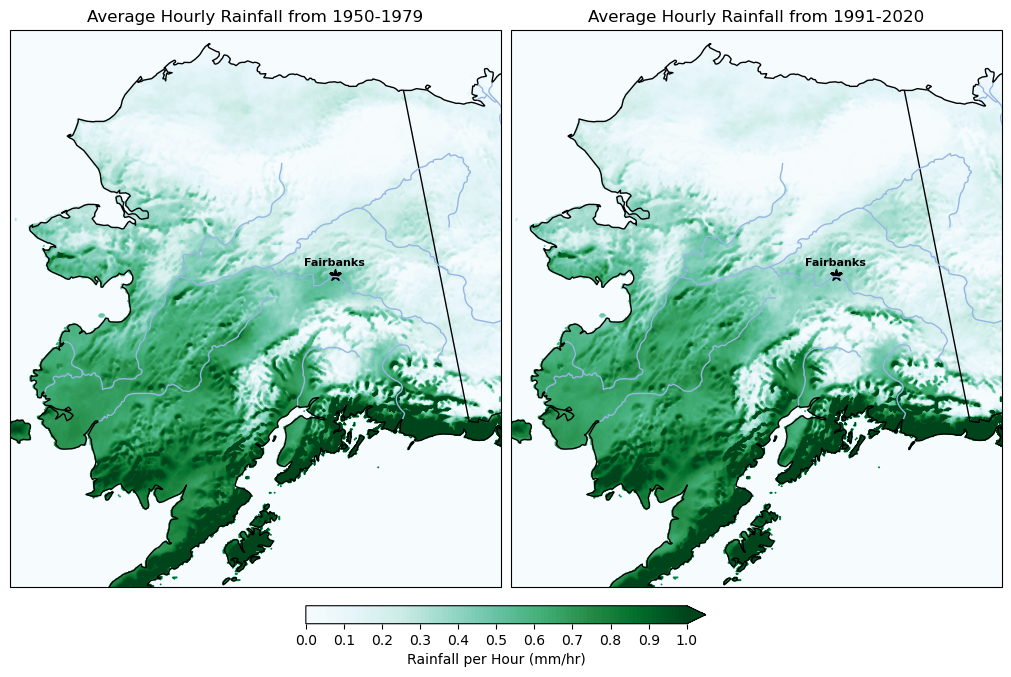

In [32]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65)
    )}
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)
levels = np.linspace(0, 1, 100) 

cf1 = axs[0].contourf(lon, lat, ros_hourly_rainfall_1950_1979, levels=levels, cmap='BuGn', extend='max', transform=ccrs.PlateCarree())
axs[0].set_title("Average Hourly Rainfall from 1950-1979")

cf2 = axs[1].contourf(lon, lat, ros_hourly_rainfall_1991_2020, levels=levels, cmap='BuGn', extend='max', transform=ccrs.PlateCarree())
axs[1].set_title("Average Hourly Rainfall from 1991-2020")

for ax in axs:
    #FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=5, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=9)
    ax.add_feature(cfeature.COASTLINE, zorder=9)
    ax.add_feature(cfeature.RIVERS, zorder=9)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
fig.colorbar(cf1, cax=cbar_ax, orientation='horizontal', label='Rainfall per Hour (mm/hr)', ticks=np.arange(0, 1.05, 0.05) [::2])

fig.patch.set_alpha(0.0)

plt.show()

/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


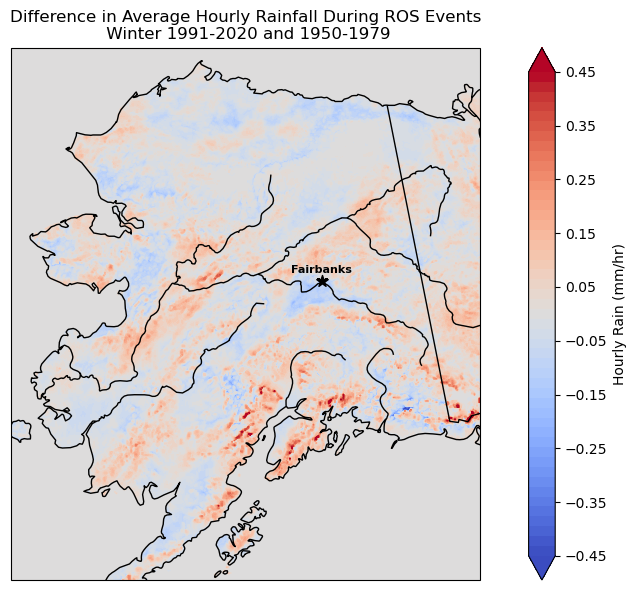

In [33]:
difference_hourly_precip=ros_hourly_rainfall_1991_2020-ros_hourly_rainfall_1950_1979

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.linspace(-0.45, .45,50) 
cmap = plt.get_cmap('coolwarm')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 6))
cf = ax.contourf(lon, lat, difference_hourly_precip, levels=levels, cmap=cmap, extend='both',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Hourly Rain (mm/hr)')
cbar.set_ticks(np.arange(-0.45, .46, 0.01)[::10])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS,color='black', zorder=9)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Difference in Average Hourly Rainfall During ROS Events\n Winter 1991-2020 and 1950-1979")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

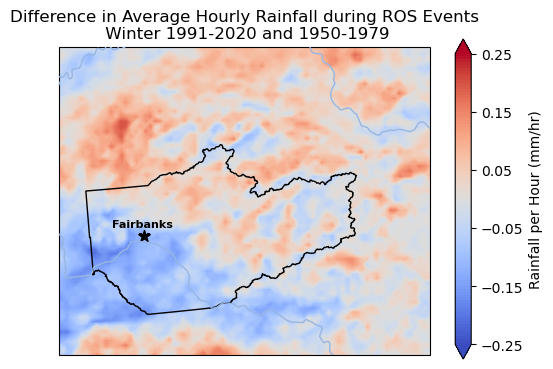

In [34]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.linspace(-0.25,.25, 100) 

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat,difference_hourly_precip, levels=levels,extend='both',cmap='coolwarm',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Rainfall per Hour (mm/hr)')
cbar.set_ticks(np.arange(-0.25,.26, 0.01) [::10])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')

ax.set_title("Difference in Average Hourly Rainfall during ROS Events\n Winter 1991-2020 and 1950-1979")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

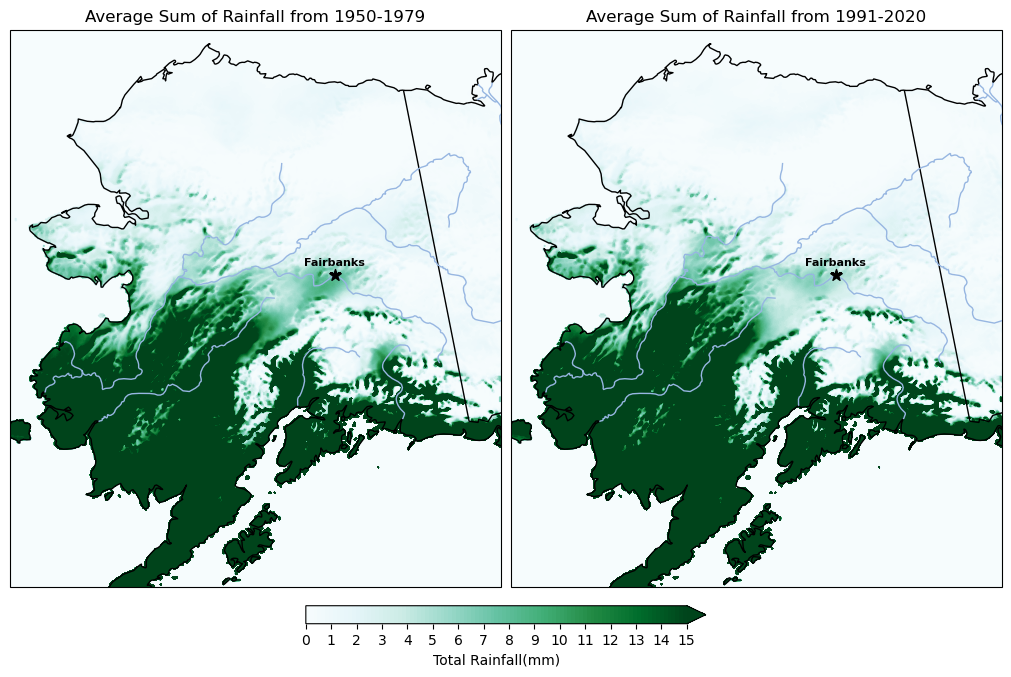

In [35]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

#fig.suptitle("Average Sum of Rainfall during ROS Events", y=0.9)
levels = np.linspace(0, 15,100) 
#ros_avgsum_rainfall_1950_1979
#ros_avgsum_rainfall_1991_2020
cf1 = axs[0].contourf(lon, lat, ros_avgsum_rainfall_1950_1979, levels=levels, cmap='BuGn', extend='max', transform=ccrs.PlateCarree())
axs[0].set_title("Average Sum of Rainfall from 1950-1979")

cf2 = axs[1].contourf(lon, lat, ros_avgsum_rainfall_1991_2020, levels=levels, cmap='BuGn', extend='max', transform=ccrs.PlateCarree())
axs[1].set_title("Average Sum of Rainfall from 1991-2020")

for ax in axs:
    #FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=9, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=7)
    ax.add_feature(cfeature.COASTLINE, zorder=7)
    ax.add_feature(cfeature.RIVERS, zorder=7)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
fig.colorbar(cf1, cax=cbar_ax, orientation='horizontal', label='Total Rainfall(mm)', ticks=np.arange(0, 15.5, 0.5)[::2])

fig.patch.set_alpha(0.0)

plt.show()

/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


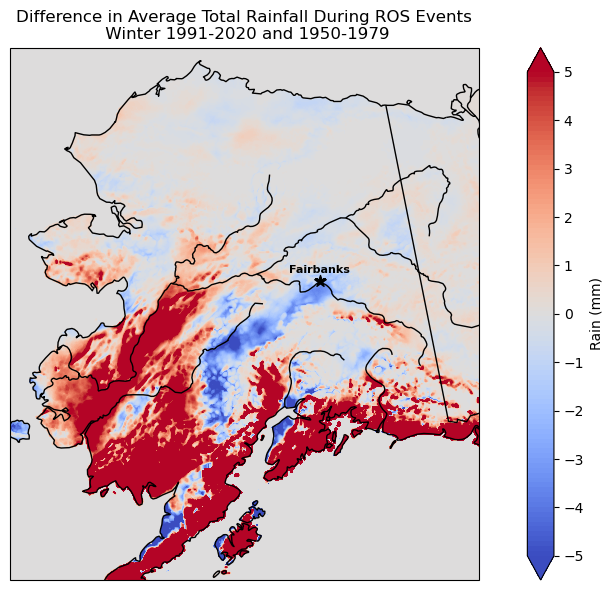

In [36]:
differenceprecip=ros_avgsum_rainfall_1991_2020-ros_avgsum_rainfall_1950_1979

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.linspace(-5, 5, 100)
ticks = np.arange(-5,5.5,.5)
cmap = plt.get_cmap('coolwarm')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 6))
cf = ax.contourf(lon, lat, differenceprecip, levels=levels, cmap=cmap, extend='both',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Rain (mm)')
cbar.set_ticks(ticks[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS,color='black', zorder=9)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Difference in Average Total Rainfall During ROS Events\n Winter 1991-2020 and 1950-1979")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

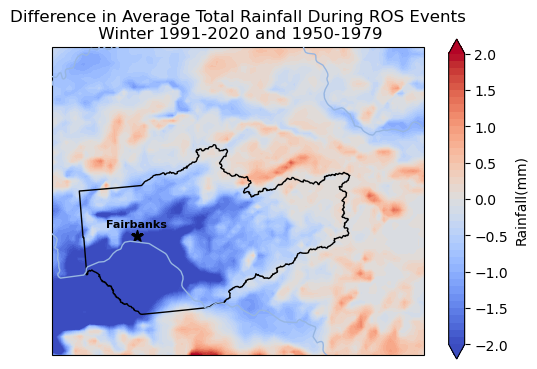

In [37]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(-2,2.1, 0.1)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat,differenceprecip, levels=levels,extend='both',cmap='coolwarm',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Rainfall(mm)')
cbar.set_ticks(levels[::5])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')

ax.set_title("Difference in Average Total Rainfall During ROS Events\n Winter 1991-2020 and 1950-1979")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()